In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('stock/'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

/tmp/ipykernel_1450/1633172487.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from datetime import date

# df_aapl=pd.read_csv("../input/Data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df = pd.read_csv('../stock/AAPL.csv', parse_dates=True, index_col=0)

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,28.950001,29.082500,28.690001,29.037500,27.174757,115127600
2017-01-04 00:00:00-05:00,28.962500,29.127501,28.937500,29.004999,27.144342,84472400
2017-01-05 00:00:00-05:00,28.980000,29.215000,28.952499,29.152500,27.282379,88774400
2017-01-06 00:00:00-05:00,29.195000,29.540001,29.117500,29.477501,27.586529,127007600
2017-01-09 00:00:00-05:00,29.487499,29.857500,29.485001,29.747499,27.839207,134247600
...,...,...,...,...,...,...
2022-12-01 00:00:00-05:00,148.210007,149.130005,146.610001,148.309998,148.309998,71250400
2022-12-02 00:00:00-05:00,145.960007,148.000000,145.649994,147.809998,147.809998,65421400
2022-12-05 00:00:00-05:00,147.770004,150.919998,145.770004,146.630005,146.630005,68826400


In [3]:
df = df[['Close']]

In [4]:
df=df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [5]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    print(data_raw.shape)
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
        
    data = np.array(data);
    # test_set_size = int(np.round(0.2*data.shape[0]));
    test_set_size = 180;
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(1494, 1)
x_train.shape =  (1294, 19, 1)
y_train.shape =  (1294, 1)
x_test.shape =  (180, 19, 1)
y_test.shape =  (180, 1)


In [11]:
y = np.array([[
                [1,2,3],
                [1,2,3],
                [1,2,3],
][
                [1,2,3],
                [1,2,3],
                [1,2,3],
]])

<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_1450/2238204267.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  y = np.array([
/tmp/ipykernel_1450/2238204267.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  y = np.array([
/tmp/ipykernel_1450/2238204267.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  y = np.array([


TypeError: list indices must be integers or slices, not tuple

In [57]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [71]:
y_train.shape, x_train.shape

((1294, 1), torch.Size([1294, 19, 1]))

In [59]:
input_dim = 1
hidden_dim = 128
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        h0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
        
        c0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
        
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # reshape output from hidden cell into [batch, features] for 'linear_2'
        x = self.dropout(x)
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=1, hidden_dim=128, num_layers=2, output_dim=1, dropout=0.2)
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#    print(list(model.parameters())[i].size())

In [60]:
''' linear and relu 
LSTM(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
12
torch.Size([32, 1])
torch.Size([32])
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
'''

''' Normal
LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
'''


' Normal\nLSTM(\n  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)\n  (dropout): Dropout(p=0.2, inplace=False)\n  (fc): Linear(in_features=32, out_features=1, bias=True)\n)\n10\ntorch.Size([128, 1])\ntorch.Size([128, 32])\ntorch.Size([128])\ntorch.Size([128])\ntorch.Size([128, 32])\ntorch.Size([128, 32])\ntorch.Size([128])\ntorch.Size([128])\ntorch.Size([1, 32])\ntorch.Size([1])\n'

In [61]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.2745843827724457
Epoch  20 MSE:  0.053533151745796204
Epoch  30 MSE:  0.0282864011824131
Epoch  40 MSE:  0.005052060354501009
Epoch  50 MSE:  0.0030582540202885866
Epoch  60 MSE:  0.001604989287443459
Epoch  70 MSE:  0.0016519742785021663
Epoch  80 MSE:  0.0014136363752186298
Epoch  90 MSE:  0.0013665914302691817


In [62]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.76 RMSE
Test Score: 5.73 RMSE


In [68]:
test = np.array([28.950001,	29.082500,	28.690001,	115127600])
test_pred = model(test)

TypeError: 'int' object is not callable

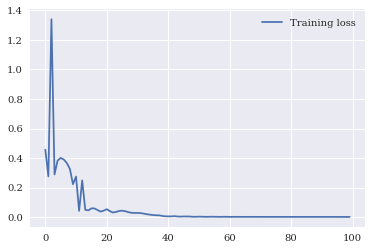

In [63]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [64]:
df[len(df)-len(y_test):].index

Index([2022-03-23 00:00:00-04:00, 2022-03-24 00:00:00-04:00,
       2022-03-25 00:00:00-04:00, 2022-03-28 00:00:00-04:00,
       2022-03-29 00:00:00-04:00, 2022-03-30 00:00:00-04:00,
       2022-03-31 00:00:00-04:00, 2022-04-01 00:00:00-04:00,
       2022-04-04 00:00:00-04:00, 2022-04-05 00:00:00-04:00,
       ...
       2022-11-23 00:00:00-05:00, 2022-11-25 00:00:00-05:00,
       2022-11-28 00:00:00-05:00, 2022-11-29 00:00:00-05:00,
       2022-11-30 00:00:00-05:00, 2022-12-01 00:00:00-05:00,
       2022-12-02 00:00:00-05:00, 2022-12-05 00:00:00-05:00,
       2022-12-06 00:00:00-05:00, 2022-12-07 00:00:00-05:00],
      dtype='object', name='Date', length=180)

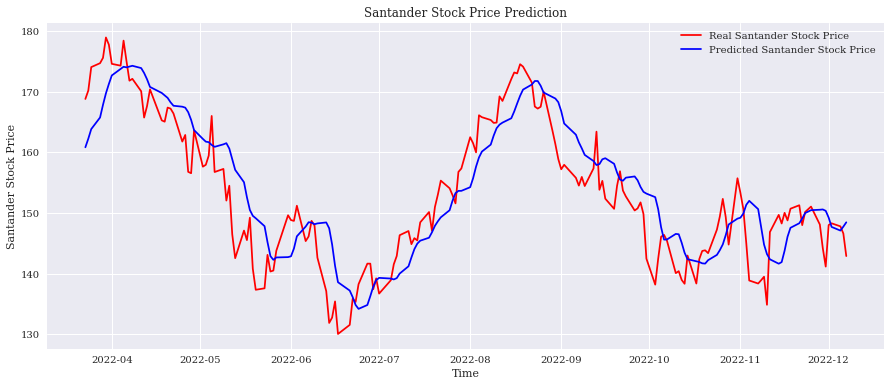

In [65]:
# Visualising the results
figure, ax = plt.subplots(figsize=(15, 6))
ax.xaxis_date()

ax.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Santander Stock Price')
ax.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Santander Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Santander Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Santander Stock Price')
plt.legend()
plt.savefig('aapl_pred.png')
plt.show()

In [66]:
df = pd.read_csv('stock/BBVA.csv')
df = df.loc[df['Date'] > "2022-09-19"]

df.set_index('Date')

df = df[['Close']]

df=df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

FileNotFoundError: [Errno 2] No such file or directory: 'stock/BBVA.csv'

In [ ]:
# function to create train, test data given stock data and sequence length
def load_data_test(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(0, len(data_raw)): 
        data.append(data_raw[index: index])

    data = np.array(data);
    # test_set_size = int(np.round(0.2*data.shape[0]));
    test = data[:,:-1]
    
    return [test]

look_back = 20

data = load_data_test(df, look_back)

,Close
1187,0.884616
1188,0.538462
1189,0.653847
1190,-0.153845
1191,-0.423077
1192,-0.846154
1193,-0.423077
1194,-0.692308
1195,-0.692308
1196,-0.115385
